# **SIN 393 – Introduction to Computer Vision (2024)**

# Lecture 06 - Part 3 - Convolutional Neural Networks

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---
* Adjust the learning rate.
* Save information:
    * Save the trained model.
    * Save the loss and accuracy plots.
    * Save the classification report.
    * Save the detailed classification report.
* Customized Dataset class:
    * Dataset splitting using Scikit-learn. 
    * Access the path to the images in validation and test sets.
    * Data augmentation.

## Mounting Google Drive
---

* If you are running on Google Colab, don't forget to enable GPU access.
    * Edit >> Laptop Settings >> Hardware Accelerator
    * Select GPU
    * OK
* After use, disable access.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

False


## Importing the required libraries
---


In [2]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from skimage import io
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler 
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, datasets, utils

## Settings for reproducibility
---
* Convolutional Neural Network (CNN) operations often rely on random numbers.
* When repeating an experiment multiple times, the results may exhibit slight variations, even when using the same data, models, and hyperparameters.
* To ensure reproducibility across different experiment runs, it is often beneficial to set fixed seeds for the random number generators.

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Checking GPU Access
---


In [4]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [5]:
!nvidia-smi

Thu Nov 28 10:33:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| 48%   35C    P5              N/A /  75W |      8MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## The dataset
---
* Flower dataset
    * https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
    * 4242 imagens de flores
    * 5 classes
 * Folder hierarch:
    * [flowers]
        * [daisy]
        * [dandelion]
        * [rose]
        * [suinflower]
        * [tulip]

In [6]:
if IN_COLAB:
    ds_path = '/content/drive/My Drive/Data/flowers-recognition/flowers/'
else:
    ### ds_path = 'data/flowers-recognition/flowers/'
    ds_path = '/home/joao/Datasets/flowers-recognition/flowers/'

## Setting up the experiment folder
---

In [7]:
EXP_PATH = './exp-lec6_p3_01/'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

## Setting hyperparameters and configurations
---

In [8]:
# Batch size (mini-batch size)
batch_size = 64
# Learning rate
lr = 0.00001
# Mommentum
mm = 0.9
# Number of training epochs
epochs = 50 # Use a small value during development, 2 for example.
# Step size - For the learning rate scheduler (StepLR).
ss = 10

In [9]:
# Select the network architecture.
ARCH_NAME = 'alexnet' # 'simplenet', 'alexnet', 'resnet18', ...
# Note: 'simplenet' refers to the architecture we developed.
# For information on additional architectures, please refer to the torchvision documentation: https://pytorch.org/vision/stable/models.html.

## Preparing the dataset
---

### Customized Dataset class

In [10]:
class FlowersDataset(Dataset):

    def __init__(self, path_list, label_list, transforms=None):
        self.path_list = path_list
        self.label_list = label_list
        self.transforms = transforms

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        path = self.path_list[idx]
        ### image = io.imread(self.path_list[idx])
        image = Image.open(self.path_list[idx]) 

        label = self.label_list[idx]

        if self.transforms:
            image = self.transforms(image)

        return (image, label, path)       

### Data transforms

In [11]:
# Training. With data augmentation
data_transforms_train = transforms.Compose([# DATA AUGMENTATION
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.RandomRotation(degrees=15),
                                            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                            transforms.GaussianBlur(kernel_size=3),
                                            # Resizes images to the size of the network input.
                                            ### transforms.Resize(size=(224, 224)),
                                            transforms.RandomResizedCrop(size=224),
                                            transforms.ToTensor(),
                                            # Normalization. ImageNet mean and standard deviation.
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                           ])

data_transforms_val = transforms.Compose([# Resizes images to the size of the network input.
                                          ### transforms.Resize(size=(224, 224)),
                                          transforms.RandomResizedCrop(size=224),
                                          transforms.ToTensor(),
                                          # Normalization. ImageNet mean and standard deviation.
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                         ])

data_transforms_test = transforms.Compose([# Resizes images to the size of the network input.
                                           ### transforms.Resize(size=(224, 224)),
                                           transforms.CenterCrop(size=224),
                                           transforms.ToTensor(),
                                           # Normalization. ImageNet mean and standard deviation.
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                          ])  

### Process the dataset file tree

In [12]:
# Class names
# ---
# Do not ensure that only folders are retrieved.
### class_names = os.listdir(ds_path)
# Ensure that only folders are retrieved.
class_names = [item for item in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, item))]
print(class_names)
# Sort the class names
class_names.sort()

# Number of classes. Corresponds to the number of subfolders in the dataset folder.
num_classes = len(class_names)

['sunflower', 'tulip', 'daisy', 'rose', 'dandelion']


In [13]:
# List with all paths to images and their respective labels
path_list = []
label_list = []

# Iterate through the class folders
for class_ in class_names:
    # Ordered list of files (images) in each folder
    path_list_ = os.listdir(os.path.join(ds_path, class_))
    path_list_.sort()

    # Iterates through the files in the current folder (class)
    for path_image in path_list_:
        file_path = os.path.join(ds_path, class_, path_image)
        path_list.append(file_path)
        label_list.append(class_)

In [14]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
TRAIN_SIZE = 1. - TEST_SIZE 

# Dictionary of index labels
le = preprocessing.LabelEncoder()
le.fit(class_names)
label_list_idx = le.transform(label_list)

# Retrieve the class names from the LabelEncoder object.
# Ensure they are properly aligned with the order defined by the model's output layer.
class_names = le.classes_
print(class_names)

# Separate TEST_SIZE from the full set for TESTING. (1. - TEST_SIZE) of the full set.
X_train_, X_test, y_train_, y_test = model_selection.train_test_split(path_list, 
                                                                      label_list_idx, 
                                                                      test_size=TEST_SIZE, 
                                                                      stratify=label_list_idx,
                                                                      random_state=42)

# Separate VAL_SIZE from the full set for VALIDATION. (VAL_SIZE / TRAIN_SIZE) of the training set.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_, 
                                                                  y_train_, 
                                                                  test_size=(VAL_SIZE / TRAIN_SIZE), 
                                                                  stratify=y_train_,
                                                                  random_state=42)

# Building the datasets using the Custom Dataset class.
train_dataset = FlowersDataset(X_train, y_train, transforms=data_transforms_train)
val_dataset = FlowersDataset(X_val, y_val, transforms=data_transforms_val)
test_dataset = FlowersDataset(X_test, y_test, transforms=data_transforms_test)

# Number of images in each split
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# DEBUG
print(train_size)
print(val_size)
print(test_size)

['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']
2589
864
864


In [15]:
# Defining the dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

### Visualizing a batch of images

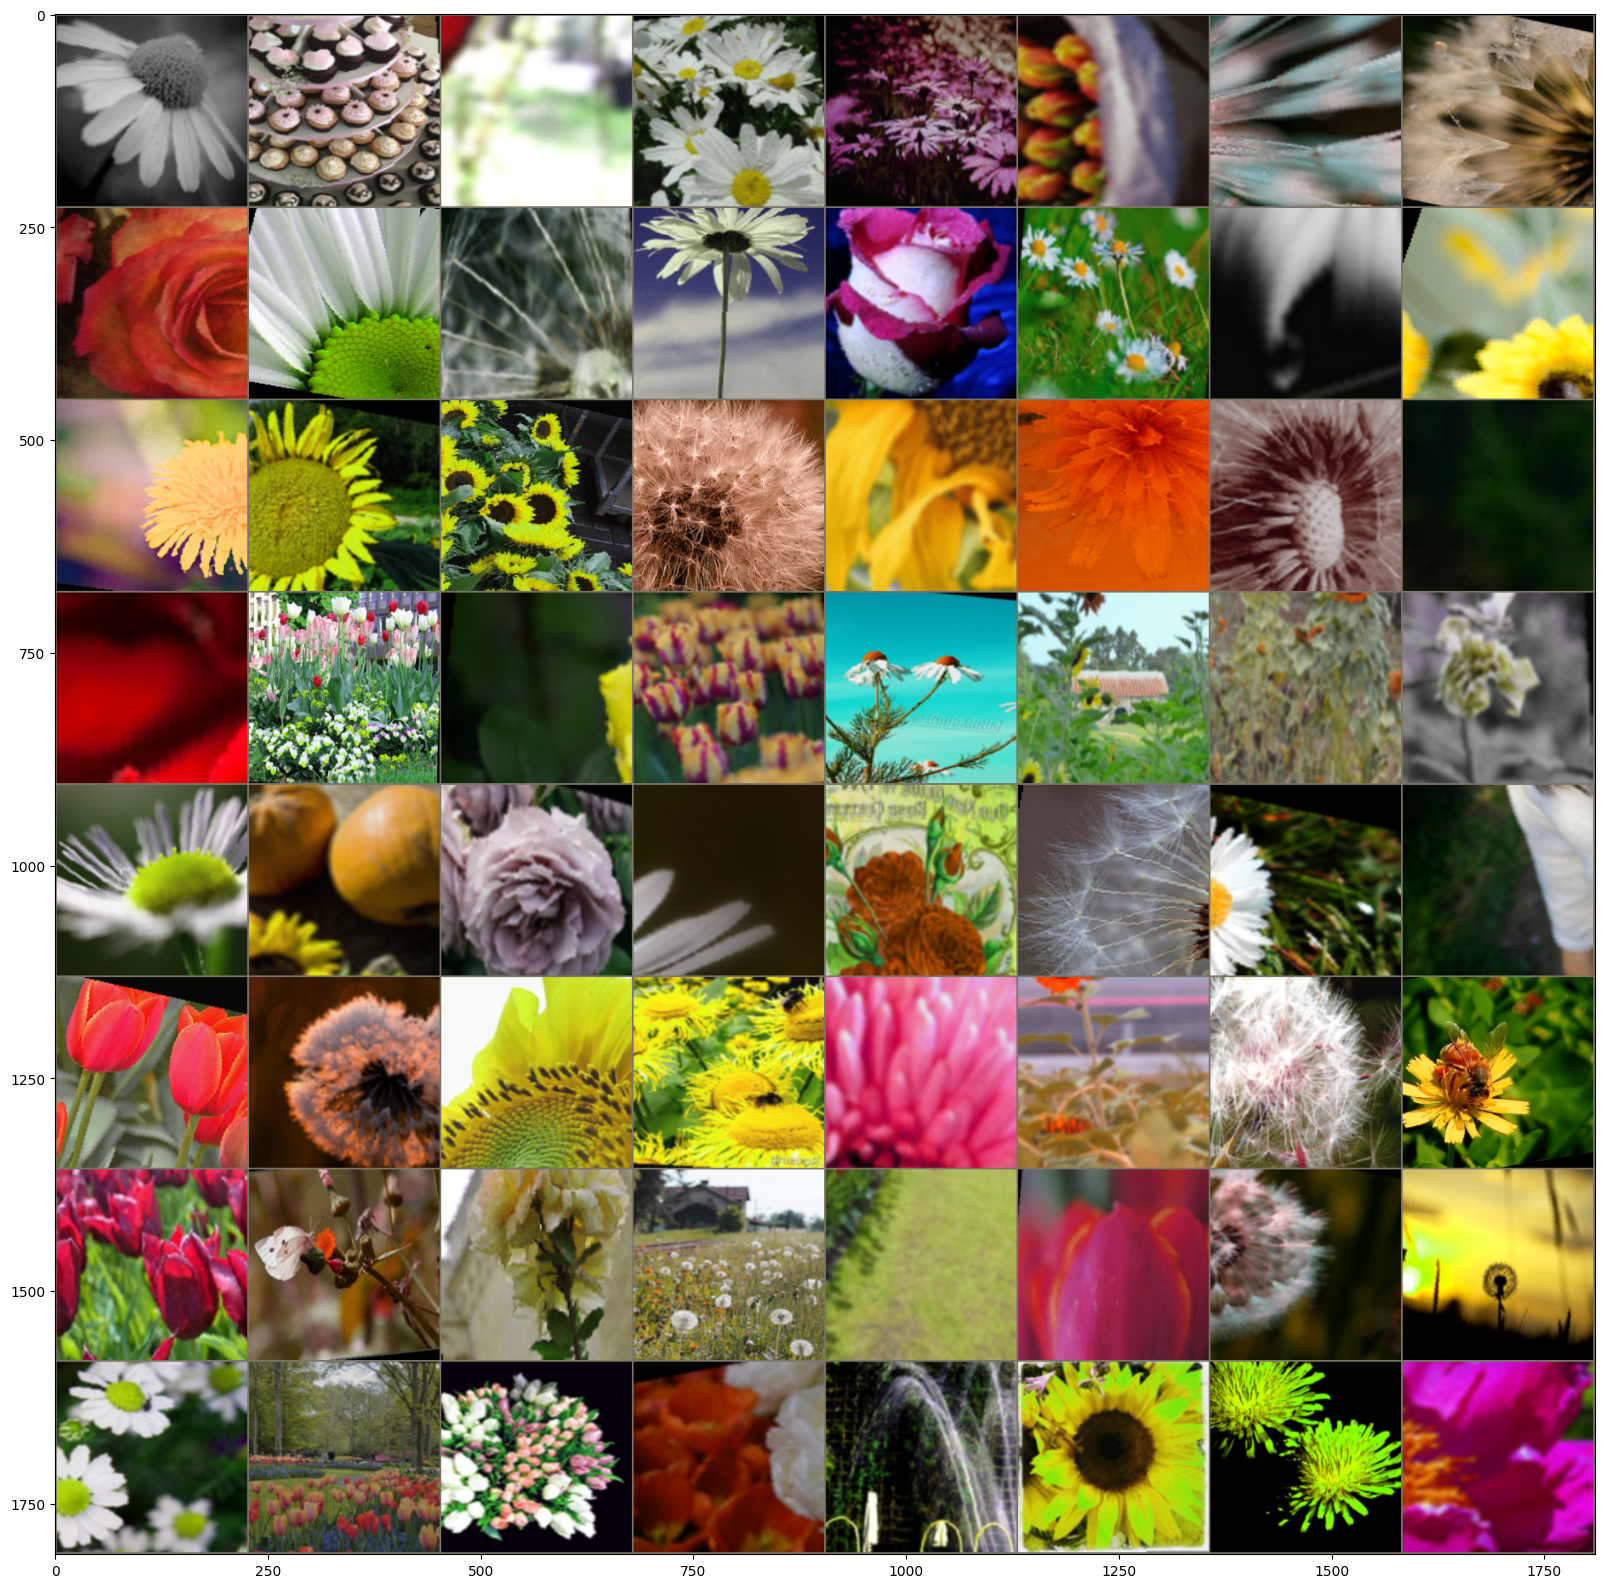

In [16]:
def show_transformed_image(image):
    # Unnormalize the channels. mageNet weights
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):        
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualize 'batch_size' images
dataloader_vis = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label, *_ = next(items)

show_transformed_image(utils.make_grid(image))

# Save the image as pdf file.
plt.savefig(os.path.join(EXP_PATH, 'sample_batch.pdf')) 

## A simple CNN architecture
---

* https://pytorch.org/docs/stable/nn.html

In [17]:
class Net(nn.Module):
    """
    Considering each image having 224 x 224 x 3:
    
    Input [3, 224, 224] 
    Conv1(3, 6, 5) [6, 220, 220] 
    Pool(2, 2) 16, 110, 110]
    Conv2(6, 16, 5) [16, 106, 106]
    Pool(2, 2) [16, 53, 53]
    Flatten [44944] (16 x 53 x 53 = 44944)
    Fc1 [120]
    Fc2 [84]
    Fc3 [num_classes]
    """
    def __init__(self, in_channels, num_classes):
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
                        dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        ---
        https://pytorch.org/docs/stable/nn.html
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 53 * 53, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        # conv1(x): Input: [224, 224, 3]. Output: [220, 220, 6].
        x = self.conv1(x)
        x = F.relu(x)
        # pool: Input: [220, 220, 6], Output: [110, 110, 6]
        x = self.pool(x)
        # conv2: Input: [110, 110, 6]. Output: [106, 106, 16].
        x = self.conv2(x)
        x = F.relu(x)
        # pool: Input: [106, 106, 16], Output: [53, 53, 16]
        x = self.pool(x)
        # flatten: Input: [53, 53, 16]. Output: [44944]
        x = torch.flatten(x, 1) 
        # fc1: Input: [44944]. Output: [120]
        x = self.fc1(x)
        x = F.relu(x)
        # fc2: Input: [120]. Output: [84]
        x = self.fc2(x)
        x = F.relu(x)
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)
        
        return x

## Using a pretrainned model (fine-tunning)
---


### Selecting the model

* https://pytorch.org/vision/stable/models.html

In [18]:
if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(224, num_classes)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)   

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    ### model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

# Include more architectures...
# ---
### elif ARCH_NAME == ...

In [19]:
# Send the model to the GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda
    
# Print the model
print(str(model))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Loss function and optimizer

* https://pytorch.org/docs/stable/optim.html

In [20]:
# Loss function
# https://pytorch.org/docs/stable/nn.html
criterion = nn.CrossEntropyLoss()

# Optimizer
# https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

# Learning rate scheduler
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)

## Training the model
---

In [21]:
# Total training time (including training and validation).
time_total_start = time.time()

# List of training losses and accuracies for each epoch.
train_loss_list = []
train_acc_list = []

# List of validation losses and accuracies for each epoch.
val_loss_list = []
val_acc_list = []

# Learning rate list
lr_list = []

for epoch in range(epochs):
    # TRAINING
    # =========================================================================
    # Starts timing the epoch.
    time_epoch_start = time.time()

    # Enables the model for training mode
    model.train() 

    # Loss for this epoch.
    loss_epoch_train = 0.0    
    # Samples correctly classified in this epoch.
    hits_epoch_train = 0  

    # Iterate along the batches of the TRAINING SET
    for inputs, labels, *_ in train_dataloader:
        # Send data to GPU
        inputs = inputs.to(DEVICE) 
        labels = labels.to(DEVICE) 

        # Zero the parameter gradients
        optimizer.zero_grad() 

        # Enable gradient calculation during training.
        torch.set_grad_enabled(True) 

        # -----> FORWARD
        # Model output
        outputs = model(inputs) 

        # 'outputs' contains float values. Take the maximum values as the predictions.
        preds = torch.argmax(outputs, dim=1).float() 

        # Compute the loss function
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward() 

        # Optimizes the parameters (weights)
        optimizer.step()

        # Updates the epoch loss
        loss_epoch_train += float(loss.item()) * inputs.size(0) 

        # Updates the epoch hits
        hits_epoch_train += torch.sum(preds == labels.data) 

    # Training loss and accuracy for this epoch.
    train_loss = loss_epoch_train / train_size
    train_acc = float(hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDATION
    # =========================================================================
    model.eval() 

    # Epoch validation loss
    loss_epoch_val = 0.0 
    # Num hits for this epoch
    hits_epoch_val = 0 
    
    # Iterate along the batches of the VALIDATION SET
    for inputs, labels, *_ in val_dataloader:

        # Send data to GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad() 

        # Disables gradient calculation during validation.
        torch.set_grad_enabled(False) 

        # -----> FORWARD
        # Model output
        outputs = model(inputs) 

        # Returns the largest prediction.
        preds = torch.argmax(outputs, dim=1).float()

        # Compute the loss
        loss = criterion(outputs, labels) 

        # Updates the epoch loss
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # Updates the epoch hits
        hits_epoch_val += torch.sum(preds == labels.data)

    # Adjust the learning rate
    scheduler.step() 

    # Store the learning rate
    lr_epoch = optimizer.param_groups[0]['lr']
    lr_list.append(lr_epoch)
        
    # Validation loss and accuracy for this epoch.
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)

    # Store val loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Total time for this epoch
    time_epoch = time.time() - time_epoch_start
    
    # PRINTING
    # --------
    print(f'Epoch {epoch}/{ epochs - 1} - TRAIN Loss: {train_loss:.4f} TRAIN Acc: {train_acc:.4f} - VAL. Loss: {val_loss:.4f} VAL. Acc: {val_acc:.4f} ({time_epoch:.4f} seconds)')

# Total training time
time_total_train = time.time() - time_total_start

# PRINTING
print(f'\nTreinamento finalizado. ({int(time_total_train // 60)}m and {int(time_total_train % 60)}s)')

Epoch 0/49 - TRAIN Loss: 1.6327 TRAIN Acc: 0.2441 - VAL. Loss: 1.5647 VAL. Acc: 0.2836 (56.2576 seconds)
Epoch 1/49 - TRAIN Loss: 1.5017 TRAIN Acc: 0.3499 - VAL. Loss: 1.3747 VAL. Acc: 0.4560 (56.4503 seconds)
Epoch 2/49 - TRAIN Loss: 1.3719 TRAIN Acc: 0.4299 - VAL. Loss: 1.2607 VAL. Acc: 0.5150 (56.1403 seconds)
Epoch 3/49 - TRAIN Loss: 1.2799 TRAIN Acc: 0.5114 - VAL. Loss: 1.1476 VAL. Acc: 0.5799 (55.4694 seconds)
Epoch 4/49 - TRAIN Loss: 1.1908 TRAIN Acc: 0.5666 - VAL. Loss: 1.0930 VAL. Acc: 0.5972 (55.9281 seconds)
Epoch 5/49 - TRAIN Loss: 1.1426 TRAIN Acc: 0.5678 - VAL. Loss: 1.0199 VAL. Acc: 0.6400 (56.1823 seconds)
Epoch 6/49 - TRAIN Loss: 1.0750 TRAIN Acc: 0.6045 - VAL. Loss: 0.9604 VAL. Acc: 0.6412 (56.5139 seconds)
Epoch 7/49 - TRAIN Loss: 1.0185 TRAIN Acc: 0.6439 - VAL. Loss: 0.9209 VAL. Acc: 0.6528 (55.9571 seconds)
Epoch 8/49 - TRAIN Loss: 0.9997 TRAIN Acc: 0.6369 - VAL. Loss: 0.8891 VAL. Acc: 0.6551 (56.9416 seconds)
Epoch 9/49 - TRAIN Loss: 0.9701 TRAIN Acc: 0.6462 - VAL

## Saving (and loading) the trained model

In [22]:
torch.save(model, os.path.join(EXP_PATH, 'model.pth'))

In [23]:
# Para carregar o modelo
### model = torch.load(os.path.join(EXP_PATH, 'model.pth'))

## Analyzing the training
---

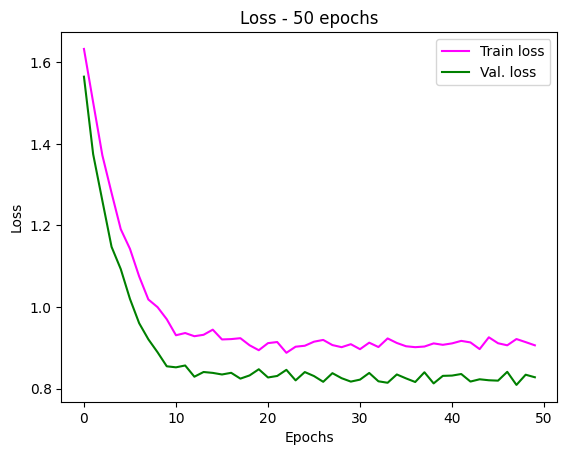

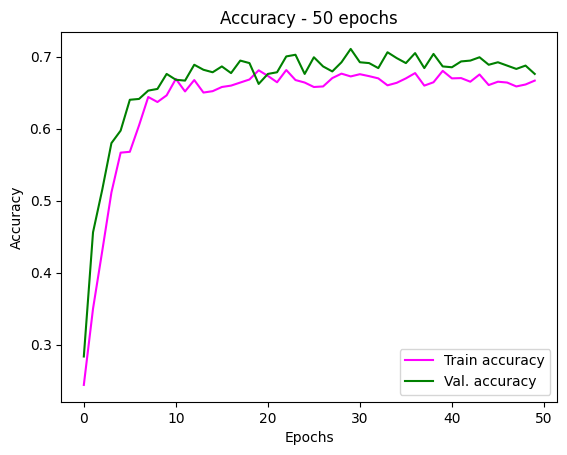

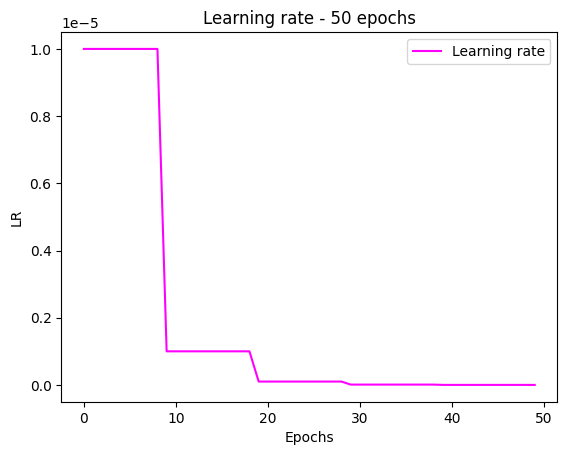

In [24]:
# List with epoch indexes. [0, 1, ... num_epochs - 1]
epochs_list = list(range(len(train_loss_list)))

# Plot - Loss 
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_loss_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'loss_history.pdf')) 

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train accuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'acc_history.pdf')) 

# Plot - LR
plt.figure()
plt.title(f'Learning rate - {epochs} epochs')
plt.plot(epochs_list, lr_list, c='magenta' ,ls='-', label='Learning rate', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('LR')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'lr_history.pdf')) 

## Evaluating the model over the TEST set
---

In [25]:
# List with true and predicted classes
true_test_list = []
pred_test_list = []
# List with probabilities
prob_test_list = []
# List with the paths to the images
path_test_list = []

# Iterate along the batches of the TEST SET
for i, (img_list, label_list, path_list) in enumerate(test_dataloader):

    # Send data to GPU
    img_list = img_list.to(DEVICE)
    label_list = label_list.to(DEVICE)

    # Disables gradient calculation during validation and testing.
    torch.set_grad_enabled(False) 

    # -----> FORWARD
    # Model output
    outputs = model(img_list)

    # Prediction
    preds = torch.argmax(outputs, dim=1)

    # Computes probabilities of each class
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    
    # True classes and predicted classes for this batch.
    if DEVICE.type == 'cuda':
        true_test_batch = list(label_list.cpu())
        pred_test_batch = list(preds.cpu())
        prob_test_batch = list(outputs_prob.cpu())
    else:
        true_test_batch = list(label_list)
        pred_test_batch = list(preds)
        prob_test_batch = list(outputs_prob)
        
    # Append batch results to the lists
    true_test_list += true_test_batch
    pred_test_list += pred_test_batch
    prob_test_list += prob_test_batch
    path_test_list += path_list

## Confusion matrix and classification report
---

In [26]:
# Confusion matrix
conf_mat_test = metrics.confusion_matrix(true_test_list, pred_test_list)
print('\nConfusion matrix (test set)')
print(conf_mat_test)

# Classification report - Scikit-learn
class_rep_test = metrics.classification_report(true_test_list, 
                                               pred_test_list, 
                                               target_names=class_names, 
                                               digits=4,
                                               zero_division=0)
print('\nClass. report (test set)')
print(class_rep_test)

# Accuracy
acc_test = metrics.accuracy_score(true_test_list, pred_test_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_test))


Confusion matrix (test set)
[[115  17   1  12   8]
 [  4 172   2  28   4]
 [  9   5  76  16  51]
 [  6   9   0 126   6]
 [  4  10  24   9 150]]

Class. report (test set)
              precision    recall  f1-score   support

       daisy     0.8333    0.7516    0.7904       153
   dandelion     0.8075    0.8190    0.8132       210
        rose     0.7379    0.4841    0.5846       157
   sunflower     0.6597    0.8571    0.7456       147
       tulip     0.6849    0.7614    0.7212       197

    accuracy                         0.7396       864
   macro avg     0.7447    0.7347    0.7310       864
weighted avg     0.7463    0.7396    0.7351       864



Validation Acc.: 0.7396


### Saving the classification report (TEST set)

In [27]:
class_rep_path = os.path.join(EXP_PATH, 'classification_report_test.txt')
file_rep = open(class_rep_path, 'w')

file_rep.write('\nTEST. SET:')
file_rep.write('\n\nConfusion matrix:\n')
file_rep.write(str(conf_mat_test))
file_rep.write('\n\nClassification report:\n')
file_rep.write(class_rep_test)
file_rep.write(f'\n\nAccuracy:\t {acc_test:.4f}')

file_rep.close()

### Detailed classification report (TEST set)

In [28]:
# Test set
class_rep_path = os.path.join(EXP_PATH, 'class_report_detailed_test.csv')
file_rep = open(class_rep_path, 'w')

print('\n#\tImage path\tTarget\tPrediction\tCorrect?', end='')
file_rep.write('\n#;Image path;Target;Prediction;Correct?')

for class_name in class_names:
    print(f'\t {class_name}', end='')
    file_rep.write(f';{class_name}')

for i, (path, true, pred, probs) in enumerate(zip(path_test_list, true_test_list, pred_test_list, prob_test_list)):
    print(f'\n{i} \t {path} \t {true} \t {pred} \t {true==pred}', end='')
    file_rep.write(f'\n{i};{path};{true};{pred};{true==pred}')

    for prob in probs:
        print(f'\t{prob:.4f}', end='')
        file_rep.write(f';{prob:.4f}')

file_rep.close()


#	Image path	Target	Prediction	Correct?	 daisy	 dandelion	 rose	 sunflower	 tulip
0 	 /home/joao/Datasets/flowers-recognition/flowers/sunflower/14925398301_55a180f919_n.jpg 	 3 	 3 	 True	0.0779	0.0994	0.0050	0.8160	0.0017
1 	 /home/joao/Datasets/flowers-recognition/flowers/daisy/5435522104_1d6a61b431_n.jpg 	 0 	 0 	 True	0.9850	0.0012	0.0033	0.0090	0.0015
2 	 /home/joao/Datasets/flowers-recognition/flowers/daisy/14330343061_99478302d4_m.jpg 	 0 	 0 	 True	0.8162	0.0428	0.0107	0.1136	0.0167
3 	 /home/joao/Datasets/flowers-recognition/flowers/rose/323872063_7264e7e018_m.jpg 	 2 	 2 	 True	0.0021	0.0042	0.8451	0.0026	0.1460
4 	 /home/joao/Datasets/flowers-recognition/flowers/tulip/18270448366_d5676dec64_z.jpg 	 4 	 4 	 True	0.0267	0.0066	0.0211	0.0035	0.9422
5 	 /home/joao/Datasets/flowers-recognition/flowers/tulip/20692409652_25da3e5839_n.jpg 	 4 	 4 	 True	0.0752	0.0344	0.2756	0.0673	0.5475
6 	 /home/joao/Datasets/flowers-recognition/flowers/tulip/7166620850_8a37b95972_n.jpg 	 4 	 4 	

## Bibliography
---
* PyTorch. Training a Classifier
    * https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* Microsoft. Train your image classifier model with PyTorch.
    * https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model
* Nathan Inkawhich. FINETUNING TORCHVISION MODELS.
    * (Broken link) https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 
    * (New link) https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/finetuning_torchvision_models_tutorial.ipynb#scrollTo=kfl9S6PnhsuC
* Sasank Chilamkurthy. TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL. 
    * https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Datasets & DataLoaders
    * https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* Writing Custom Datasets, DataLoaders and Transforms
    * https://pytorch.org/tutorials/beginner/data_loading_tutorial.html